In [1]:
# LIBRARY:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

import statsmodels as sa

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline
%matplotlib nbagg

%cd /Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES/

#%cd /Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/LogisticRegression_tests

/Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES


In [2]:
# Import dataset:

df = pd.read_csv('GTEX-ALL_SAMPLES.v8.phASER.gw_phased.results.fdr_ALL.gene_info.zscores.txt.gz', sep='\t', compression='gzip')
#df = pd.read_csv('GTEX-FEMALES.v8.phASER_WASP.gw_phased.BetaBinom_vs_LogisticReg.BRAIN.gene_info.zscores.txt', sep='\t')
# add column for GENE_IDs without version #:
df[['GENE_ID','ens_version']] = df['GENE_ID'].str.split('.',expand=True)

df.head()

/Users/snkravitz/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,mean_read_counts,total_sample_count_females,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,ens_version
0,1,ENSG00000228794,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,58.0,133.0,NaN,414,74.0,0.178744,0.315991,private_RME,8
1,1,ENSG00000223764,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,38.0,173.0,NaN,492,132.0,0.268293,0.915775,private_RME,2
2,1,ENSG00000188976,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,178.0,179.0,NaN,532,48.0,0.090226,-0.276891,private_RME,10
3,1,ENSG00000187961,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,24.0,160.0,NaN,473,34.0,0.071882,-0.399756,private_RME,13
4,1,ENSG00000187583,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,96.0,194.0,NaN,566,47.0,0.083039,-0.325026,private_RME,10


In [5]:
#df[['GENE_ID','ens_version']] = df['GENE_ID'].str.split('.',expand=True)

#df.head()

ValueError: Columns must be same length as key

In [3]:
## Filter out X-Chr genes, Imprinted genes, and HLA genes:

# Remove X-Chr:
df = df[df['CHR'] != 'X']

# Remove HLA genes:
df = df[~df['GENE_NAME'].str.contains("HLA")]

# Remove Imprinted Genes:
imprinted_df = pd.read_csv("~/Documents/Gene_Lists/GTEx_Imprinting/GTEx_Imprinted_Table_S3andS4.uniq.txt", sep=' ', names=['GENE_ID', 'chrom', 'start'])
imprinted_genes = list(imprinted_df['GENE_ID'])
#imprinted_genes
df = df[~df['GENE_ID'].isin(imprinted_genes)]

In [4]:
df[['GENE_ID', 'z_score']].drop_duplicates().shape

(25762, 2)

In [5]:
## First get the median TPM across tissues (from GTEx data downloads):
med_tpms = pd.read_csv('/Users/snkravitz/Documents/GTEx_Summary_Data/GTEx_v8_StudyFiles/GTEx.v8.all-tissues.gene_median_tpm.info.txt', sep='\t')
med_tpms[['GENE_ID','ens_version']] = med_tpms['GENE_ID'].str.split('.',expand=True)
med_tpms.head()


,GENE_ID,GENE_NAME,median_tpms,num_tissues_expressed,ens_version
0,ENSG00000000003,TSPAN6,9.527640,56,14
1,ENSG00000000005,TNMD,0.201407,50,5
2,ENSG00000000419,DPM1,50.049600,56,12
3,ENSG00000000457,SCYL3,6.007240,56,13
4,ENSG00000000460,C1orf112,1.973760,56,16


In [10]:
## First get the median TPM across tissues (from GTEx data downloads):

#gene_tpms = pd.read_csv('/Users/snkravitz/Documents/GTEx_Summary_Data/GTEx_v8_StudyFiles/GTEx.v8.all-tissues.gene_median_tpm.info.txt', sep='\t')
#gene_tpms.head()

# Get median TPM across all tissues:
#med_tpms = gene_tpms.set_index(['Name', 'Description']).median(axis=1).to_frame()
#med_tpms.reset_index(inplace=True)
#med_tpms.rename(columns={0:'med_tpm', 'Name':'GENE_ID'}, inplace=True)
# add column for GENE_IDs without version #:
#med_tpms[['GENE_ID','ens_version']] = med_tpms['GENE_ID'].str.split('.',expand=True)

#med_tpms.head()


NameError: name 'med_tpms' is not defined

In [15]:
# Merge median Z-score to med_tpms

df_tpms = med_tpms.merge(df[['GENE_ID', 'z_score']].drop_duplicates(), how='inner', on='GENE_ID')
#df_tpms = med_tpms.merge(df[['GENE_ID', 'zscores_logr_binom_95']].drop_duplicates(), how='inner', on='GENE_ID')

In [16]:
df_tpms.head()

,GENE_ID,GENE_NAME,median_tpms,num_tissues_expressed,ens_version,z_score
0,ENSG00000000419,DPM1,50.04960,56,12,-0.619828
1,ENSG00000000457,SCYL3,6.00724,56,13,-0.149095
2,ENSG00000000460,C1orf112,1.97376,56,16,1.860492
3,ENSG00000000938,FGR,6.13408,56,12,-0.729558
4,ENSG00000000971,CFH,24.34690,56,15,2.340941


In [17]:
## Plotting z-score vs. expression (i.e. mean_counts):

# Get deciles of mean_counts:
## Where the deciles are based on the RANGE of med_tpms (therefore the bins will not have equal # of genes)

uniq_counts = df_tpms['med_tpm'].unique()

pctiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

pctile_counts = []
for p in pctiles:
    pctile_counts.append(np.percentile(uniq_counts, p, interpolation='nearest'))
    
print(pctile_counts)

# Subset df by mean read counts (deciles):
expression_dfs = []
for index, p in enumerate(pctile_counts[0:len(pctile_counts)-1]):
    lower = p
    upper = pctile_counts[index + 1]
    df_subset = df_tpms['zscores_logr_binom_95'][df_tpms['med_tpm'].between(lower, upper)].to_frame()
    df_subset['percentile'] = (index + 1) * 10
    expression_dfs.append(df_subset)

df_pctile_vals = pd.concat(expression_dfs, ignore_index=True)

# merge percentiles with original df:
df_tpm = df_tpms.merge(df_pctile_vals['percentile'], left_index=True, right_index=True)
df_tpm.head()

KeyError: 'med_tpm'

<IPython.core.display.Javascript object>


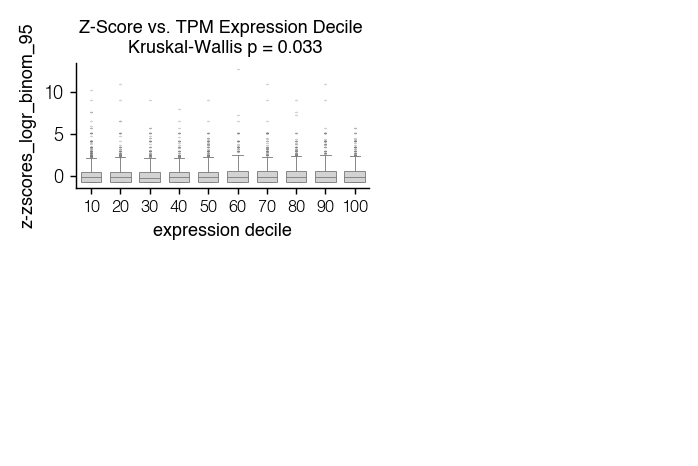

Text(0.5, 1.0, 'Z-Score vs. TPM Expression Decile \n Kruskal-Wallis p = 0.033')

In [95]:
# Plot Z-Score vs. Expression (decile)
f, ax = plt.subplots(figsize=(3,2), tight_layout=True)
sns.despine()

df_tpm = df_tpm.dropna()

#anova_p = stats.f_oneway(*(df_tpm[df_tpm['percentile'] == p]['z_score'].dropna() for p in np.linspace(10,100, 10)))
kruskal_p = stats.kruskal(*(df_tpm[df_tpm['percentile'] == p]['zscores_logr_binom_95'].dropna() for p in np.linspace(10,100, 10)))

ax = sns.boxplot(data=df_tpm, x = 'percentile', y = 'zscores_logr_binom_95', linewidth=0.5, fliersize=0.1, width=0.7, color="lightgray")
ax.set_xlabel('expression decile', fontsize=10)
ax.set_ylabel('z-zscores_logr_binom_95', fontsize=10)
ax.set_xticklabels(np.linspace(10,100, 10).astype(int), size=9)
ax.set_title('Z-Score vs. TPM Expression Decile \n Kruskal-Wallis p = %.2g' % kruskal_p.pvalue, fontsize=10)

#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.expression_decile.vs.z-score.pdf', transparent=True)


In [96]:
## Plotting Z-Scores vs. expression (i.e. median TPMS):

# Get deciles of med_tpms:
## Where the deciles are EVENLY binned, i.e. sort the data by med_tpms, and slice evenly

df_tpm = df_tpm.sort_values(by='med_tpm').reset_index()

expression_bins = np.linspace(0,df_tpm.shape[0], 20).astype(int)
print(expression_bins)

# Subset df by mean read counts (deciles):
expression_deciles = []
for index, p in enumerate(expression_bins[0:len(expression_bins)-1]):
    lower = p
    upper = expression_bins[index + 1]
    df_subset = df_tpm.iloc[lower:upper]
    #df_subset = df['data_qvalues'][df['mean_read_counts'].between(lower, upper)].to_frame()
    df_subset['percentile'] = (index + 1) * 5
    expression_deciles.append(df_subset)
    
df_pctile_vals = pd.concat(expression_deciles, ignore_index=True)

[    0   903  1807  2711  3615  4518  5422  6326  7230  8134  9037  9941
 10845 11749 12653 13556 14460 15364 16268 17172]


<ipython-input-96-90d2f3ac51d0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['percentile'] = (index + 1) * 5


<IPython.core.display.Javascript object>


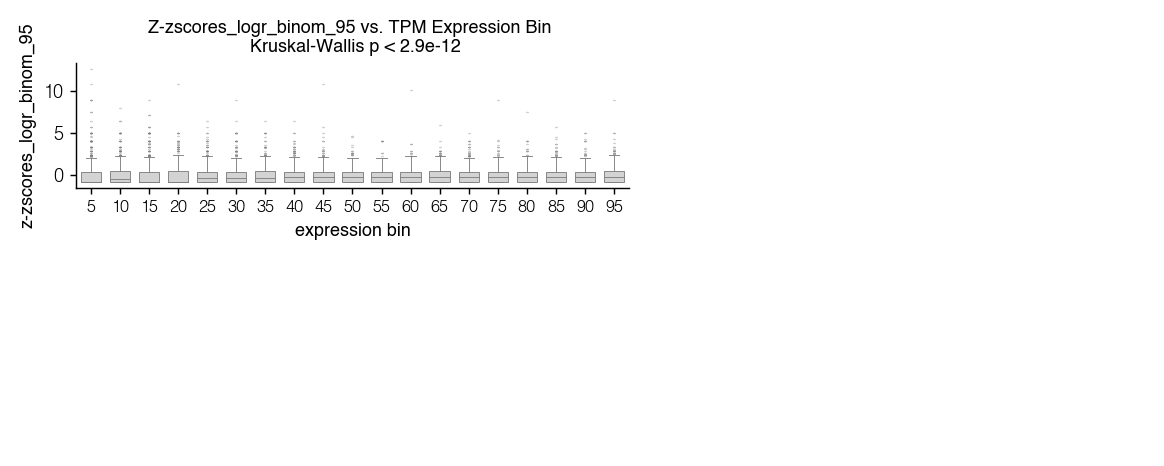

Text(0.5, 1.0, 'Z-zscores_logr_binom_95 vs. TPM Expression Bin \n Kruskal-Wallis p < 2.9e-12')

In [97]:
# Plot Z-Score vs. Expression (bins)
f, ax = plt.subplots(figsize=(5,2), tight_layout=True)
sns.despine()

#anova_p = stats.f_oneway(*(df_pctile_vals[df_pctile_vals['percentile'] == p]['z_score'].dropna() for p in np.linspace(5,95, 19)))
kruskal_p = stats.kruskal(*(df_pctile_vals[df_pctile_vals['percentile'] == p]['zscores_logr_binom_95'].dropna() for p in np.linspace(5,95, 19)))


ax = sns.boxplot(data=df_pctile_vals, x = 'percentile', y = 'zscores_logr_binom_95', linewidth=0.5, fliersize=0.1, width=0.7, color="lightgray")
ax.set_xlabel('expression bin', fontsize=10)
ax.set_ylabel('z-zscores_logr_binom_95', fontsize=10)
ax.set_xticklabels(np.linspace(5,95, 19).astype(int), size=9)
ax.set_title('Z-zscores_logr_binom_95 vs. TPM Expression Bin \n Kruskal-Wallis p < %.2g' % kruskal_p.pvalue, fontsize=10)
             
#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.expression_bins.vs.z-score.pdf', transparent=True)

In [20]:
df_tpms.head()

,GENE_ID,Description,med_tpm,ens_version,z_score
0,ENSG00000227232,WASH7P,3.617360,5,NaN
1,ENSG00000268903,RP11-34P13.15,3.411975,1,4.995202
2,ENSG00000228463,AP006222.2,0.356770,9,-0.881208
3,ENSG00000230021,RP5-857K21.4,0.043179,8,1.569513
4,ENSG00000237973,MTCO1P12,47.706100,1,NaN


<IPython.core.display.Javascript object>


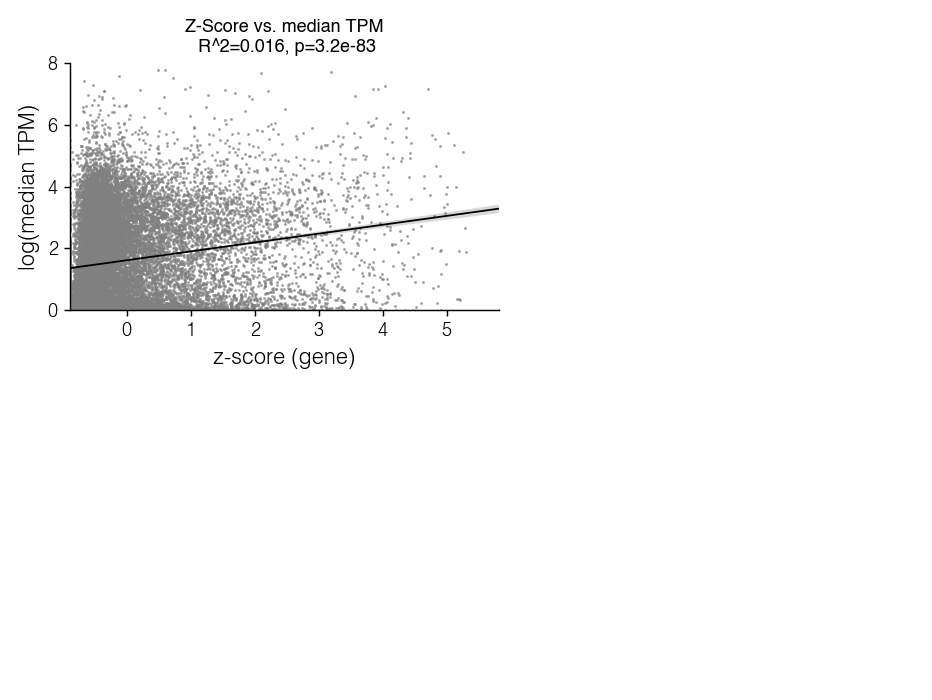

In [38]:
f, ax = plt.subplots(figsize=(4,3), tight_layout=True)
sns.despine()

df_tpm = df_tpms.dropna()

#slope, intercept, r_value, p_value, std_err = stats.linregress(df_tpm['zscores_logr_binom_95'],df_tpm['med_tpm'])
slope, intercept, r_value, p_value, std_err = stats.linregress(df_tpm['z_score'],df_tpm['med_tpm'])
r_squared = r_value ** 2

ax = sns.regplot(data=df_tpm, x=df_tpm['z_score'], y=np.log1p(df_tpm['med_tpm']), fit_reg=True, truncate=True, ci=95, scatter_kws={"color":"grey", "s": 0.5, "alpha": 0.6, 'rasterized': True}, line_kws={"color":"black", "lw":1})
ax.set_xlabel('z-score (gene)', fontsize=12, fontweight='light')
ax.set_ylabel('log(median TPM)', fontsize=12, fontweight='light')
ax.set_ylim(0, 8)
#ax.set_xlim(0, 20)
ax.set_title('Z-Score vs. median TPM\n R^2={0:.2g}, p={1:.2g}'.format(r_squared,p_value), fontsize=10)

#plt.show()

#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.expression.vs.z-score_regplot.pdf', dpi=400, transparent=True)
#f.savefig('GTEX-FEMALES.brain-tissues.expression.vs.LogisticReg_z-score_regplot.pdf', dpi=400, transparent=True)


In [20]:
## Subset RME and Biallelic genes (and 'Unknown'):

df_tpms['mosaic_category'] = np.where(df_tpms['z_score'] >= 0.74, 'RME', 'Unknown')
df_tpms['mosaic_category'] = np.where(df_tpms['z_score'] < 0, 'Biallelic', df_tpms['mosaic_category'])

df_tpms.head()

,GENE_ID,GENE_NAME,median_tpms,num_tissues_expressed,ens_version,z_score,mosaic_category
0,ENSG00000000419,DPM1,50.04960,56,12,-0.619828,Biallelic
1,ENSG00000000457,SCYL3,6.00724,56,13,-0.149095,Biallelic
2,ENSG00000000460,C1orf112,1.97376,56,16,1.860492,RME
3,ENSG00000000938,FGR,6.13408,56,12,-0.729558,Biallelic
4,ENSG00000000971,CFH,24.34690,56,15,2.340941,RME


<IPython.core.display.Javascript object>


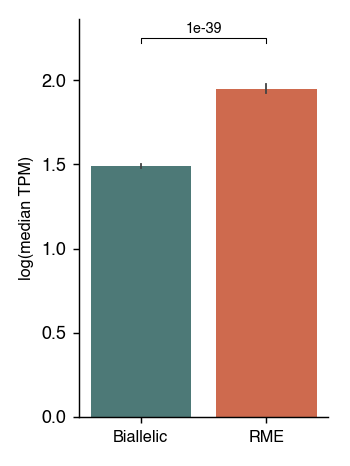

In [27]:
## Plot boxplot of Biallelic vs. RME genes for median TPMs:

f, ax = plt.subplots(figsize=(1.5, 2), tight_layout=True)
sns.despine()

#kw_pval = stats.kruskal(chromHMM_count[chromHMM_count['mosaic_category'] == 'RME']['state_label_mnemonic'], chromHMM_count[chromHMM_count['mosaic_category'] == 'Biallelic']['state_label_mnemonic'], nan_policy='omit')
f_oneway = stats.f_oneway(df_tpms[df_tpms['mosaic_category'] == 'Biallelic']['median_tpms'], df_tpms[df_tpms['mosaic_category'] == 'RME']['median_tpms'])

#x_axis_vals = [0, 1]
#y_vals = [chromHMM_count['state_label_mnemonic'].max() + (chromHMM_count['state_label_mnemonic'].max() * .05)]
#h, col = (chromHMM_count['state_label_mnemonic'].max() * .01), 'k'
#for x1, x2, y in zip(x_axis_vals[0::2], x_axis_vals[1::2], y_vals[0:]):
#    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.6, c=col)
#    ax.text((x1+(x2-x1)/2), y+h, "%.2g" % kw_pval.pvalue, ha='center', va='bottom', color=col, fontsize=8)

#ax = sns.boxplot(x='mosaic_category', y=chromHMM_count['state_label_mnemonic'], data=chromHMM_count[chromHMM_count['mosaic_category'] != 'Unknown'], order=["Biallelic", "RME"], linewidth=0.5, whis=1, width=0.7, palette=["#46807D","#E35E39"], showfliers=True, fliersize=1)
ax = sns.barplot(x='mosaic_category', y=np.log1p(df_tpms['median_tpms']), data=df_tpms[df_tpms['mosaic_category'] != 'Unknown'], order=["Biallelic", "RME"], palette=["#46807D","#E35E39"], ci=68, errwidth=1)
ax.plot([0, 0, 1, 1], [2.22, 2.25, 2.25, 2.22], lw=0.6, c='k')
ax.text(0.5, 2.26, "%.2g" % f_oneway.pvalue, ha='center', va='bottom', color='k', fontsize=8)
ax.set_ylabel("log(median TPM)", fontsize=9, fontweight='light')
ax.set_xlabel("")
ax.set_xticklabels(['Biallelic', 'RME'], fontsize=9)

#plt.show()

#plt.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.expression.vs.z-score_barplot.ci68.pdf', transparent=True)


In [26]:
df_tpm[df_tpm['mosaic_category'] != 'Unknown'].shape

(19883, 6)

<IPython.core.display.Javascript object>


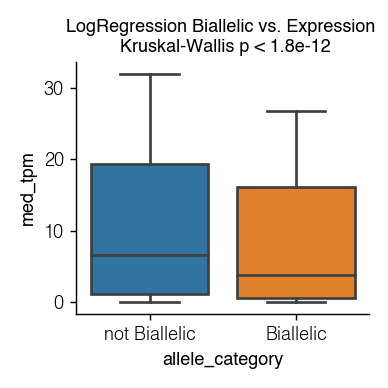

In [101]:
## expression Boxplots of "biallelic" vs not biallelic genes:

df_tpm['allele_category'] = np.where(df_tpm['zscores_logr_binom_95'] >= 1.3, 'Biallelic', 'not Biallelic')
#df_tpm.head()

f, ax = plt.subplots(figsize=(3,3), tight_layout=True)
sns.despine()

#ax = sns.boxplot(data=df_tpm, x='allele_category', y=np.log(df_tpm['med_tpm']))

kruskal_p = stats.kruskal(df_tpm[df_tpm['allele_category'] == 'not Biallelic']['med_tpm'], df_tpm[df_tpm['allele_category'] == 'Biallelic']['med_tpm'])

ax = sns.boxplot(data=df_tpm, x='allele_category', y=df_tpm['med_tpm'], whis=0.7, showfliers=False)
ax.set_title('LogRegression Biallelic vs. Expression \n Kruskal-Wallis p < %.2g' % kruskal_p.pvalue, fontsize=10)

#f.savefig('GTEX-FEMALES.brain-tissues.expression.vs.LogisticReg_z-score_boxplots.pdf', transparent=True)
